# Proyecto 3 - Minería de datos
***Universidad del Valle de Guatemala***

___24 de marzo, 2025___

**Autores:**
- Daniel Alfredo Rayo Roldán
- Gerardo Pineda
- Juan Luis

# Introducción


# Situación Problemática

## Objetivos Generales

## Objetivos Específicos

In [14]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score

# Descripción de los datos
Para iniciar el estudio se estrajeron las observaciones de divorcios hechas por el INE sobre el tema desde los años del 2013 hasta el 2023 (11 años). Se partió con un *dataset* con 76669 observaciones y 19 variables.

Se necesito hacer una cierta preprocesado, dado que las disposición y nombre de las variables cambio ligeramente a lo largo de los años, diferencias que se unificaron en las siguientes variables finales, con las que se trabajara a partir de ahora:

**Variables númericas:**

| Descripcion | Codificación | Categoría Nula |
|-----------------|-------|----|
| Edad del hombre | EDADHOM  | 999 |
| Edad de la mujer | EDADMUJ | 999 |

**Variables categóricas:**
| Descripcion | Codificación | Categoría Nula | 
|-----------------------------------|-------|---|
| Departamento de registro          | DEPREG |
| Municipio de registro             | MUPREG   |
| Mes de registro                   | MESREG   |
| Año de registro                   | AÑOREG   |
| Día de ocurrencia                 | DIAOCU |
| Mes de ocurrencia                 | MESOCU  |
| Año de ocurrencia                 | AÑOOCU |
| Departamento de ocurrencia        | DEPOCU |
| Municipio de ocurrencia           |  MUPOCU |
| Grupo étnico del hombre           | PUEHOM | 9 |
| Grupo étnico de la mujer          | PUEMUJ | 9 |
| Nacionalidad del hombre           | NACHOM | 9999 | 
| Nacionalidad de la mujer          | NACMUJ | 9999 |
| Escolaridad del hombre            | ESCHOM | 9 | 
| Escolaridad de la mujer           | ESCMUJ | 9 |
| Ocupación del hombre              | CIUOHOM | 99 | 
| Ocupación de la mujer             | CIUOMUJ | 99 |

***Nota:*** *La "categoría nula" para las variables en las que aplica, indica ese valor reservado para observaciones "sin definir", se podrían considerar como un equivalente del Nan.*


In [15]:
import pandas as pd
import glob

# Step 1: Get all CSV file paths
csv_files = glob.glob("data/*.CSV")

# Step 2: Define a generator to read and process each file on the fly
def read_and_clean(file):
    df = pd.read_csv(file)
    return df

# Step 3: Merge without storing copies
merged_df = pd.concat((read_and_clean(file) for file in csv_files), ignore_index=True)

numerical_var = ["EDADHOM", "EDADMUJ"]
categorical_var = [
    "DEPREG",
    "MUPREG",
    "MESREG",
    "AÑOREG",
    "DIAOCU",
    "MESOCU",
    "AÑOOCU",
    "DEPOCU",
    "MUPOCU",
    "PUEHOM", 
    "PUEMUJ", 
    "NACHOM", 
    "NACMUJ", 
    "ESCHOM", 
    "ESCMUJ", 
    "CIUOMUJ", 
    "CIUOHOM"]

In [16]:
DEPREG = {
    1: "Guatemala",
    2: "El Progreso",
    3: "Sacatepéquez",
    4: "Chimaltenango",
    5: "Escuintla",
    6: "Santa Rosa",
    7: "Sololá",
    8: "Totonicapán",
    9: "Quetzaltenango",
    10: "Suchitepéquez",
    11: "Retalhuleu",
    12: "San Marcos",
    13: "Huehuetenango",
    14: "Quiché",
    15: "Baja Verapaz",
    16: "Alta Verapaz",
    17: "Petén",
    18: "Izabal",
    19: "Zacapa",
    20: "Chiquimula",
    21: "Jalapa",
    22: "Jutiapa"
}

In [17]:
MUPREG = {
    "0101": "Guatemala",
    "0102": "Santa Catarina Pinula",
    "0103": "San José Pinula",
    "0104": "San José del Golfo",
    "0105": "Palencia",
    "0106": "Chinautla",
    "0107": "San Pedro Ayampuc",
    "0108": "Mixco",
    "0109": "San Pedro Sacatepéquez",
    "0110": "San Juan Sacatepéquez",
    "0111": "San Raymundo",
    "0112": "Chuarrancho",
    "0113": "Fraijanes",
    "0114": "Amatitlán",
    "0115": "Villa Nueva",
    "0116": "Villa Canales",
    "0117": "Petapa",
    "0201": "Guastatoya",
    "0202": "Morazán",
    "0203": "San Agustín Acasaguastlán",
    "0204": "San Cristóbal Acasaguastlán",
    "0205": "El Jícaro",
    "0206": "Sansare",
    "0207": "Sanarate",
    "0208": "San Antonio la Paz",
    "0301": "Antigua Guatemala",
    "0302": "Jocotenango",
    "0303": "Pastores",
    "0304": "Sumpango",
    "0305": "Santo Domingo Xenacoj",
    "0306": "Santiago Sacatepéquez",
    "0307": "San Bartolomé Milpas Altas",
    "0308": "San Lucas Sacatepéquez",
    "0309": "Santa Lucía Milpas Altas",
    "0310": "Magdalena Milpas Altas",
    "0311": "Santa María de Jesús",
    "0312": "Ciudad Vieja",
    "0313": "San Miguel Dueñas",
    "0314": "Alotenango",
    "0315": "San Antonio Aguas Calientes",
    "0316": "Santa Catarina Barahona",
    "0401": "Chimaltenango",
    "0402": "San José Poaquil",
    "0403": "San Martín Jilotepeque",
    "0404": "Comalapa",
    "0405": "Santa Apolonia",
    "0406": "Tecpán Guatemala",
    "0407": "Patzún",
    "0408": "Pochuta",
    "0409": "Patzicía",
    "0410": "Santa Cruz Balanyá",
    "0411": "Acatenango",
    "0412": "Yepocapa",
    "0413": "San Andrés Itzapa",
    "0414": "Parramos",
    "0415": "Zaragoza",
    "0416": "El Tejar",
    "0501": "Escuintla",
    "0502": "Santa Lucía Cotzumalguapa",
    "0503": "La Democracia",
    "0504": "Siquinalá",
    "0505": "Masagua",
    "0506": "Tiquisate",
    "0507": "La Gomera",
    "0508": "Guanagazapa",
    "0509": "San José",
    "0510": "Iztapa",
    "0511": "Palín",
    "0512": "San Vicente Pacaya",
    "0513": "Nueva Concepción",
    "0514": "Sipacate",
    "0601": "Cuilapa",
    "0602": "Barberena",
    "0603": "Santa Rosa de Lima",
    "0604": "Casillas",
    "0605": "San Rafael las Flores",
    "0606": "Oratorio",
    "0607": "San Juan Tecuaco",
    "0608": "Chiquimulilla",
    "0609": "Taxisco",
    "0610": "Santa María Ixhuatán",
    "0611": "Guazacapán",
    "0612": "Santa Cruz Naranjo",
    "0613": "Pueblo Nuevo Viñas",
    "0614": "Nueva Santa Rosa",
    "0701": "Sololá",
    "0702": "San José Chacayá",
    "0703": "Santa María Visitación",
    "0704": "Santa Lucía Utatlán",
    "0705": "Nahualá",
    "0706": "Santa Catarina Ixtahuacán",
    "0707": "Santa Clara la Laguna",
    "0708": "Concepción",
    "0709": "San Andrés Semetabaj",
    "0710": "Panajachel",
    "0711": "Santa Catarina Palopó",
    "0712": "San Antonio Palopó",
    "0713": "San Lucas Tolimán",
    "0714": "Santa Cruz la Laguna",
    "0715": "San Pablo la Laguna",
    "0716": "San Marcos la Laguna",
    "0717": "San Juan la Laguna",
    "0718": "San Pedro la Laguna",
    "0719": "Santiago Atitlán",
    "0801": "Totonicapán",
    "0802": "San Cristóbal Totonicapán",
    "0803": "San Francisco el Alto",
    "0804": "San Andrés Xecul",
    "0805": "Momostenango",
    "0806": "Santa María Chiquimula",
    "0807": "Santa Lucía la Reforma",
    "0808": "San Bartolo",
    "0901": "Quetzaltenango",
    "0902": "Salcajá",
    "0903": "Olintepeque",
    "0904": "San Carlos Sija",
    "0905": "Sibilia",
    "0906": "Cabricán",
    "0907": "Cajolá",
    "0908": "San Miguel Siguilá",
    "0909": "Ostuncalco",
    "0910": "San Mateo",
    "0911": "Concepción Chiquirichapa",
    "0912": "San Martín Sacatepéquez",
    "0913": "Almolonga",
    "0914": "Cantel",
    "0915": "Huitán",
    "0916": "Zunil",
    "0917": "Colomba",
    "0918": "San Francisco la Unión",
    "0919": "El Palmar",
    "0920": "Coatepeque",
    "0921": "Génova",
    "0922": "Flores Costa Cuca",
    "0923": "La Esperanza",
    "0924": "Palestina de los Altos",
    "1001": "Mazatenango",
    "1002": "Cuyotenango",
    "1003": "San Francisco Zapotitlán",
    "1004": "San Bernardino",
    "1005": "San José el Idolo",
    "1006": "Santo Domingo Suchitepéquez",
    "1007": "San Lorenzo",
    "1008": "Samayac",
    "1009": "San Pablo Jocopilas",
    "1010": "San Antonio Suchitepéquez",
    "1011": "San Miguel Panán",
    "1012": "San Gabriel",
    "1013": "Chicacao",
    "1014": "Patulul",
    "1015": "Santa Bárbara",
    "1016": "San Juan Bautista",
    "1017": "Santo Tomás la Unión",
    "1018": "Zunilito",
    "1019": "Pueblo Nuevo",
    "1020": "Río Bravo",
    "1021": "San José La Máquina",
    "1101": "Retalhuleu",
    "1102": "San Sebastián",
    "1103": "Santa Cruz Muluá",
    "1104": "San Martín Zapotitlán",
    "1105": "San Felipe",
    "1106": "San Andrés Villa Seca",
    "1107": "Champerico",
    "1108": "Nuevo San Carlos",
    "1109": "El Asintal",
    "1201": "San Marcos",
    "1202": "San Pedro Sacatepéquez",
    "1203": "San Antonio Sacatepéquez",
    "1204": "Comitancillo",
    "1205": "San Miguel Ixtahuacán",
    "1206": "Concepción Tutuapa",
    "1207": "Tacaná",
    "1208": "Sibinal",
    "1209": "Tajumulco",
    "1210": "Tejutla",
    "1211": "San Rafael Pié de la Cuesta",
    "1212": "Nuevo Progreso",
    "1213": "El Tumbador",
    "1214": "El Rodeo",
    "1215": "Malacatán",
    "1216": "Catarina",
    "1217": "Ayutla",
    "1218": "Ocós",
    "1219": "San Pablo",
    "1220": "El Quetzal",
    "1221": "La Reforma",
    "1222": "Pajapita",
    "1223": "Ixchiguán",
    "1224": "San José Ojetenán",
    "1225": "San Cristóbal Cucho",
    "1226": "Sipacapa",
    "1227": "Esquipulas Palo Gordo",
    "1228": "Río Blanco",
    "1229": "San Lorenzo",
    "1230": "La Blanca",
    "1301": "Huehuetenango",
    "1302": "Chiantla",
    "1303": "Malacatancito",
    "1304": "Cuilco",
    "1305": "Nentón",
    "1306": "San Pedro Necta",
    "1307": "Jacaltenango",
    "1308": "Soloma",
    "1309": "Ixtahuacán",
    "1310": "Santa Bárbara",
    "1311": "La Libertad",
    "1312": "La Democracia",
    "1313": "San Miguel Acatán",
    "1314": "San Rafael la Independencia",
    "1315": "Todos Santos Cuchumatán",
    "1316": "San Juan Atitán",
    "1317": "Santa Eulalia",
    "1318": "San Mateo Ixtatán",
    "1319": "Colotenango",
    "1320": "San Sebastián Huehuetenango",
    "1321": "Tectitán",
    "1322": "Concepción Huista",
    "1323": "San Juan Ixcoy",
    "1324": "San Antonio Huista",
    "1325": "San Sebastián Coatán",
    "1326": "Barillas",
    "1327": "Aguacatán",
    "1328": "San Rafael Petzal",
    "1329": "San Gaspar Ixchil",
    "1330": "Santiago Chimaltenango",
    "1331": "Santa Ana Huista",
    "1332": "Unión Cantinil",
    "1333": "Petatán",
    "1401": "Santa Cruz del Quiché",
    "1402": "Chiché",
    "1403": "Chinique",
    "1404": "Zacualpa",
    "1405": "Chajul",
    "1406": "Chichicastenango",
    "1407": "Patzité",
    "1408": "San Antonio Ilotenango",
    "1409": "San Pedro Jocopilas",
    "1410": "Cunén",
    "1411": "San Juan Cotzal",
    "1412": "Joyabaj",
    "1413": "Nebaj",
    "1414": "San Andrés Sajcabajá",
    "1415": "Uspantán",
    "1416": "Sacapulas",
    "1417": "San Bartolomé Jocotenango",
    "1418": "Canillá",
    "1419": "Chicamán",
    "1420": "Ixcán",
    "1421": "Pachalum",
    "1501": "Salamá",
    "1502": "San Miguel Chicaj",
    "1503": "Rabinal",
    "1504": "Cubulco",
    "1505": "Granados",
    "1506": "El Chol",
    "1507": "San Jerónimo",
    "1508": "Purulhá",
    "1601": "Cobán",
    "1602": "Santa Cruz Verapaz",
    "1603": "San Cristóbal Verapaz",
    "1604": "Tactic",
    "1605": "Tamahú",
    "1606": "Tucurú",
    "1607": "Panzós",
    "1608": "Senahú",
    "1609": "San Pedro Carchá",
    "1610": "San Juan Chamelco",
    "1611": "Lanquín",
    "1612": "Cahabón",
    "1613": "Chisec",
    "1614": "Chahal",
    "1615": "Fray Bartolomé de las Casas",
    "1616": "Santa Catalina la Tinta",
    "1617": "Raxruhá",
    "1701": "Flores",
    "1702": "San José",
    "1703": "San Benito",
    "1704": "San Andrés",
    "1705": "La Libertad",
    "1706": "San Francisco",
    "1707": "Santa Ana",
    "1708": "Dolores",
    "1709": "San Luis",
    "1710": "Sayaxché",
    "1711": "Melchor de Mencos",
    "1712": "Poptún",
    "1713": "Las Cruces",
    "1714": "El Chal",
    "1801": "Puerto Barrios",
    "1802": "Livingston",
    "1803": "El Estor",
    "1804": "Morales",
    "1805": "Los Amates",
    "1901": "Zacapa",
    "1902": "Estanzuela",
    "1903": "Río Hondo",
    "1904": "Gualán",
    "1905": "Teculután",
    "1906": "Usumatlán",
    "1907": "Cabañas",
    "1908": "San Diego",
    "1909": "La Unión",
    "1910": "Huité",
    "1911": "San Jorge",
    "2001": "Chiquimula",
    "2002": "San José La Arada",
    "2003": "San Juan Ermita",
    "2004": "Jocotán",
    "2005": "Camotán",
    "2006": "Olopa",
    "2007": "Esquipulas",
    "2008": "Concepción Las Minas",
    "2009": "Quetzaltepeque",
    "2010": "San Jacinto",
    "2011": "Ipala",
    "2101": "Jalapa",
    "2102": "San Pedro Pinula",
    "2103": "San Luis Jilotepeque",
    "2104": "San Manuel Chaparrón",
    "2105": "San Carlos Alzatate",
    "2106": "Monjas",
    "2107": "Mataquescuintla",
    "2201": "Jutiapa",
    "2202": "El Progreso",
    "2203": "Santa Catarina Mita",
    "2204": "Agua Blanca",
    "2205": "Asunción Mita",
    "2206": "Yupiltepeque",
    "2207": "Atescatempa",
    "2208": "Jerez",
    "2209": "El Adelanto",
    "2210": "Zapotitlán",
    "2211": "Comapa",
    "2212": "Jalpatagua",
    "2213": "Conguaco",
    "2214": "Moyuta",
    "2215": "Pasaco",
    "2216": "San José Acatempa",
    "2217": "Quesada"
}

In [18]:
MESREG = {
    1: "Enero",
    2: "Febrero",
    3: "Marzo",
    4: "Abril",
    5: "Mayo",
    6: "Junio",
    7: "Julio",
    8: "Agosto",
    9: "Septiembre",
    10: "Octubre",
    11: "Noviembre",
    12: "Diciembre"
}

In [19]:
MESOCU = MESREG

In [20]:
DEPOCU = DEPREG

In [21]:
MUPOCU = MUPREG

In [22]:
PUEHOM = PUEMUJ = {
    1: "Maya",
    2: "Garífuna",
    3: "Xinka",
    4: "Mestizo / Ladino",
    5: "Otro",
    9: "Ignorado"
}

In [23]:
ESCHOM = ESCMUJ = {
    1: "Ninguno",
    2: "Primaria",
    3: "Básica",
    4: "Diversificado",
    5: "Universitario",
    6: "Postgrado",
    9: "Ignorado"
}

In [24]:
ocupationsExcel = pd.read_excel('./data/Ocupaciones.xls')
CIUOHOM = CIUOMUJ = dict(zip(ocupationsExcel.iloc[:, 0], ocupationsExcel.iloc[:, 1]))
del ocupationsExcel

## Análisis de variables
Con la base de datos preparada, se procedio a inspeccionar las caracteristicas y frencuencias de las diferentes variables con el fin de determinar si algunas podrian ser descartadas o simplificadas debido a la poca información que ofrecen.

Sin embargo, es primero importante describir la distribución de datos nulos en cada uno de las variables: 

In [25]:
df_null_values = merged_df[["EDADHOM", "EDADMUJ", "PUEHOM", "PUEMUJ", "NACHOM", "NACMUJ", "ESCHOM", "ESCMUJ", "CIUOMUJ", "CIUOHOM"]]
null_values = {
    "EDADHOM": 999,
    "EDADMUJ": 999,
    "PUEHOM": 9,
    "PUEMUJ": 9,
    "NACHOM": 9999,
    "NACMUJ": 9999,
    "ESCHOM": 9,
    "ESCMUJ": 9,
    "CIUOMUJ": 99,
    "CIUOHOM": 99
}

# function to count null-like values
def count_nulls(df, column, null_value):
    # Count how many times the null_value appears in the column
    return (df[column] == null_value).sum()

null_counts = {col: count_nulls(merged_df, col, null_vals) for col, null_vals in null_values.items()}

null_counts_df = pd.DataFrame(list(null_counts.items()), columns=["Variable", "Frecuencia de valores nulos"])
total_rows = len(merged_df)
null_counts_df["% de valores nulos"] = (null_counts_df["Frecuencia de valores nulos"] / total_rows) * 100
null_counts_df["% de valores nulos"] = null_counts_df["% de valores nulos"].round(1)

null_counts_df

,Variable,Frecuencia de valores nulos,% de valores nulos
0,EDADHOM,34573,45.1
1,EDADMUJ,34521,45.0
2,PUEHOM,37606,49.0
3,PUEMUJ,37726,49.2
4,NACHOM,298,0.4
5,NACMUJ,306,0.4
6,ESCHOM,33234,43.3
7,ESCMUJ,32856,42.9
8,CIUOMUJ,23712,30.9
9,CIUOHOM,19831,25.9


Se puede observar que en todas las variables donde hay posibilidad de haber datos nulos, hay un porcentaje considerable, siendo en los menores las variables de *Nacionalidad*, y las mayores las variables de *Grupo étnico*. Para el tratamiento de dichas se hicieron los siguientes tratamientos:

**Datos atípicos**
Se removieron las filas que presentaban datos atípicos en cualquiera de las variables

In [26]:
def remove_outliers(dataframe):
    '''
    return a dataframe without rows that are outliers in any column
    '''
    return dataframe\
    .loc[:, lambda df: df.std() > 0.04]\
    .loc[lambda df: (np.abs(stats.zscore(df)) < 3).all(axis=1)]
print(merged_df.shape)
a = remove_outliers(merged_df)
print(a.shape)
merged_df = remove_outliers(merged_df)

(76669, 19)
(76291, 19)


**Datos nulos**


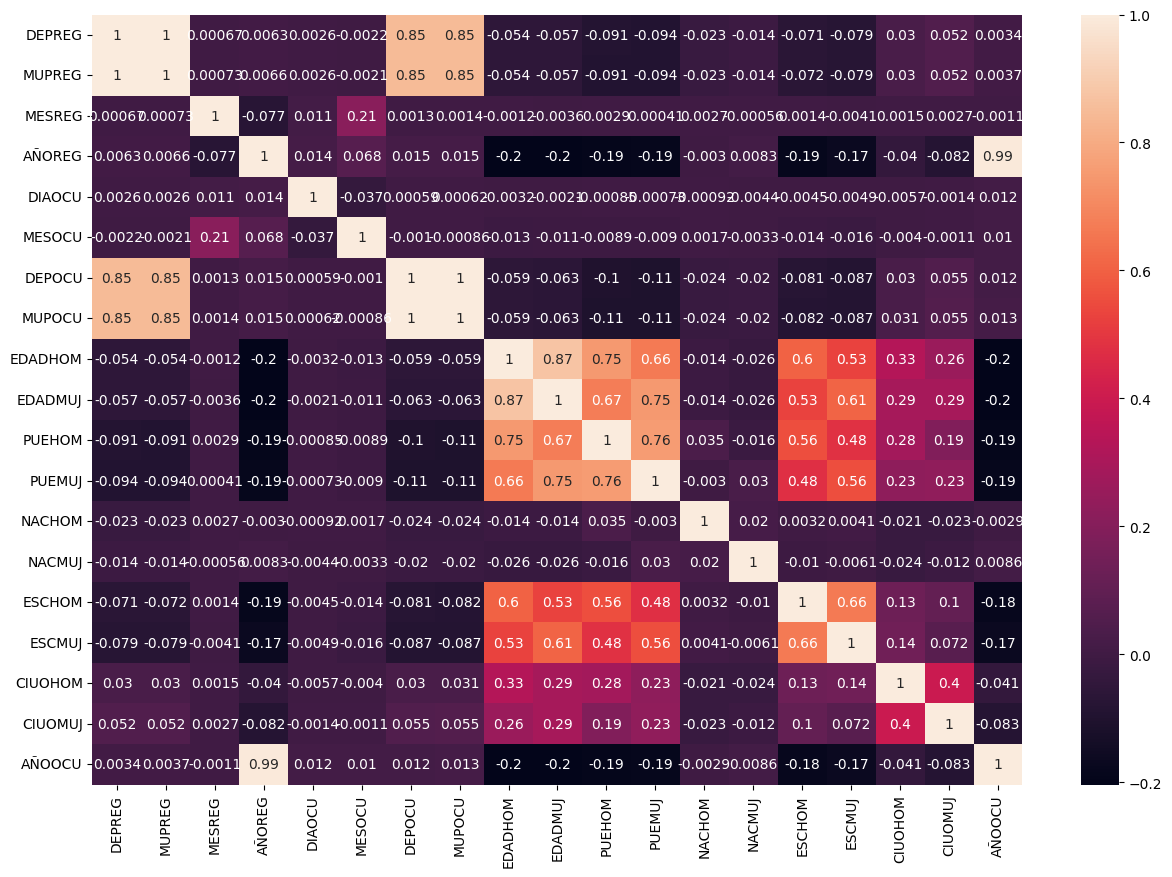

In [27]:
# 2. 
corr = merged_df.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns, annot=True, )
%matplotlib inline

In [ ]:
from catboost import CatBoostClassifier
def fill_column_with_rf(df, col, null_val):
    '''
    Fills a single column with missing values using RandomForestClassifier.
    
    Args:
        df: DataFrame containing the data with missing values.
        col: The column to fill.
        null_val: The value representing missing data.
    
    Returns:
        A pandas Series with the filled column values.
    '''
    # Create a copy of the dataframe to avoid modifying the original
    df_copy = df.copy()

    # Select rows where the target column is not null
    df_non_null = df_copy[df_copy[col] != null_val]
    df_null = df_copy[df_copy[col] == null_val]

    # Prepare X (features) and Y (target)
    X_train = df_non_null.drop(columns=[col])
    Y_train = df_non_null[col]

    # Prepare the test set (only the rows with missing values)
    X_test = df_null.drop(columns=[col])

    # Initialize the RandomForest model
    forest = RandomForestClassifier(n_estimators=45, max_depth=25, random_state=0, 
                                    max_features=0.6, min_samples_leaf=3, n_jobs=-1)

    # Train the model
    forest.fit(X_train, Y_train)

    # Predict missing values for the test set
    y_pred_train = forest.predict(X_train)
    y_pred = forest.predict(X_test)
    
    # Print accuracy for training data (optional, since we don't have Y_test)
    accuracy_train = accuracy_score(Y_train, y_pred_train)
    print(f"Accuracy for {col}: TRAIN={accuracy_train:.4f}")

    # Get feature importances and plot them
    importances = forest.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Return the filled column (imputed values)
    return pd.Series(y_pred, index=df_null.index)
def fill_column_with_catboost(df, col, null_val):
    '''
    Fills a single column with missing values using CatBoostClassifier.
    
    Args:
        df: DataFrame containing the data with missing values.
        col: The column to fill.
        null_val: The value representing missing data.
    
    Returns:
        A pandas Series with the filled column values.
    '''
    # Create a copy of the dataframe to avoid modifying the original
    df_copy = df.copy()

    # Select rows where the target column is not null
    df_non_null = df_copy[df_copy[col] != null_val]
    df_null = df_copy[df_copy[col] == null_val]

    # Prepare X (features) and Y (target)
    X_train = df_non_null.drop(columns=[col])
    Y_train = df_non_null[col]

    # Prepare the test set (only the rows with missing values)
    X_test = df_null.drop(columns=[col])

    # Initialize the CatBoost model
    cat = CatBoostClassifier(iterations=100, depth=10, learning_rate=0.1, verbose=0)

    # Train the model
    cat.fit(X_train, Y_train)

    # Predict missing values for the test set
    y_pred_train = cat.predict(X_train)
    y_pred = cat.predict(X_test)
    
    # Print accuracy for training data (optional, since we don't have Y_test)
    accuracy_train = accuracy_score(Y_train, y_pred_train)
    print(f"Accuracy for {col}: TRAIN={accuracy_train:.4f}")

    # Get feature importances and plot them
    importances = cat.get_feature_importance()
    indices = np.argsort(importances)[::-1]
    
    plt.title(f"Feature Importances for {col}")
    plt.barh(range(len(indices)), importances[indices], color="g", align="center")
    plt.yticks(range(len(indices)), X_train.columns[indices])
    plt.gca().invert_yaxis()
    plt.show()

    # Return the filled column (imputed values)
    return pd.Series(y_pred, index=df_null.index)

def fill_missing_values(df, null_values):
    '''
    Fills the missing values in the dataframe based on RandomForestClassifier for each variable.
    
    Args:
        df: DataFrame containing the data with missing values.
        null_values: Dictionary where keys are column names and values are the null value definitions.
    
    Returns:
        DataFrame with missing values filled using Random Forest.
    '''
    # Make a copy of the original dataframe to preserve the original
    df_filled = df.copy()

    # Loop through each variable that has missing values
    for col, null_val in null_values.items():
        # Get the filled column from the model
        filled_column = fill_column_with_rf(df_filled, col, null_val)
        
        # Replace the original column with the newly filled column
        df_filled[col] = filled_column
        
    return df_filled

variables_to_predict = {
    "EDADHOM": 999,
    "EDADMUJ": 999,
    "PUEHOM": 9,
    "PUEMUJ": 9,
    "ESCHOM": 9,
    "ESCMUJ": 9,
    "CIUOMUJ": 99,
    "CIUOHOM": 99
}

# Assuming merged_df is your dataframe with missing values
filled_df = fill_missing_values(merged_df, variables_to_predict)

EDADHOM
Unique classes in training set: [17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 93 98]


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74], got [17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88
 90 93 98]

In [ ]:
# function to count null-like values
def count_nulls(df, column, null_value):
    # Count how many times the null_value appears in the column
    return (df[column] == null_value).sum()

null_counts = {col: count_nulls(filled_df, col, null_vals) for col, null_vals in null_values.items()}

null_counts_df = pd.DataFrame(list(null_counts.items()), columns=["Variable", "Frecuencia de valores nulos"])
total_rows = len(filled_df)
null_counts_df["% de valores nulos"] = (null_counts_df["Frecuencia de valores nulos"] / total_rows) * 100
null_counts_df["% de valores nulos"] = null_counts_df["% de valores nulos"].round(1)

print(filled_df.shape)
null_counts_df

(76291, 19)


,Variable,Frecuencia de valores nulos,% de valores nulos
0,EDADHOM,0,0.0
1,EDADMUJ,0,0.0
2,PUEHOM,0,0.0
3,PUEMUJ,0,0.0
4,ESCHOM,0,0.0
5,ESCMUJ,0,0.0
6,CIUOMUJ,0,0.0
7,CIUOHOM,0,0.0


**Variables cuantitativas:**
En este dataset solo se cuenta con 2 variables númericas que indican la edad de la pareja que se divorcio en cuestión. Ignorando los datos nulos, la distribución de los 

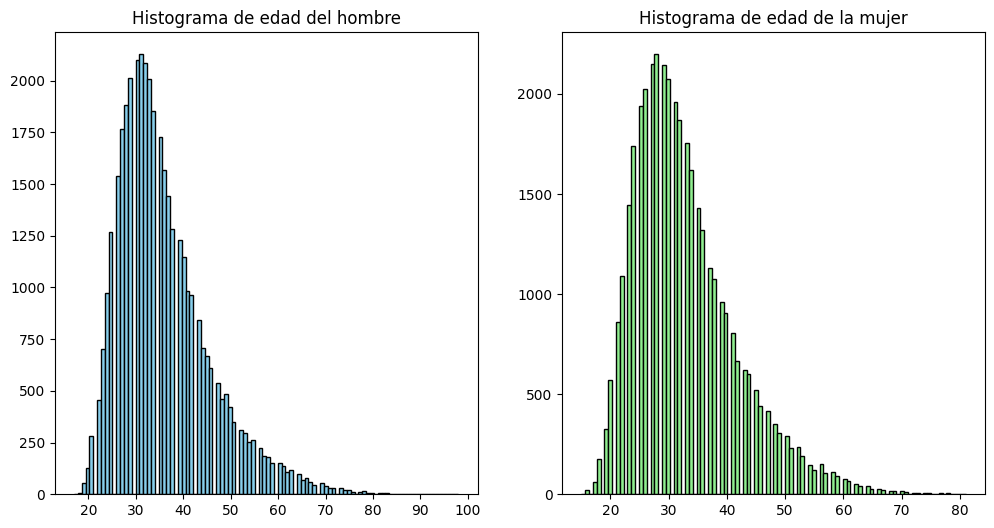

In [ ]:
df_filtered = merged_df[(merged_df['EDADHOM'] != 999) & (merged_df['EDADMUJ'] != 999)]
# Plotting histograms
plt.figure(figsize=(12, 6))

# Plotting variable_1
plt.subplot(1, 2, 1)  # (rows, columns, position)
plt.hist(df_filtered['EDADHOM'], bins=100, color='skyblue', edgecolor='black')
plt.title('Histograma de edad del hombre')

# Plotting variable_2
plt.subplot(1, 2, 2)
plt.hist(df_filtered['EDADMUJ'], bins=100, color='lightgreen', edgecolor='black')
plt.title('Histograma de edad de la mujer')
%matplotlib inline

# Análisis exploratorio

## Variables cuantitativas

## Variables cualitativas

## Preguntas exploratorias (5 preguntas mínimo)

## Análisis por clustering

# Hallazgos y conclusiones